In [1]:
using FourierFlows
using JLD2
using CairoMakie

include("TwoLayerRaytracing.jl")

using .Raytracing

In [2]:
nx, dt, prob = set_up_problem("initial_condition_U0.1.jld2", "FilteredRK4", CPU())
grid = prob.grid

# Fix because this initial condition file actually has q as the streamfunction
ic_file = jldopen("initial_condition_U0.1.jld2")
index = keys(ic_file["snapshots/t"])[1]
qh = ic_file["snapshots/ψh/$index"]
@. prob.sol = qh
MultiLayerQG.updatevars!(prob)
close(ic_file)

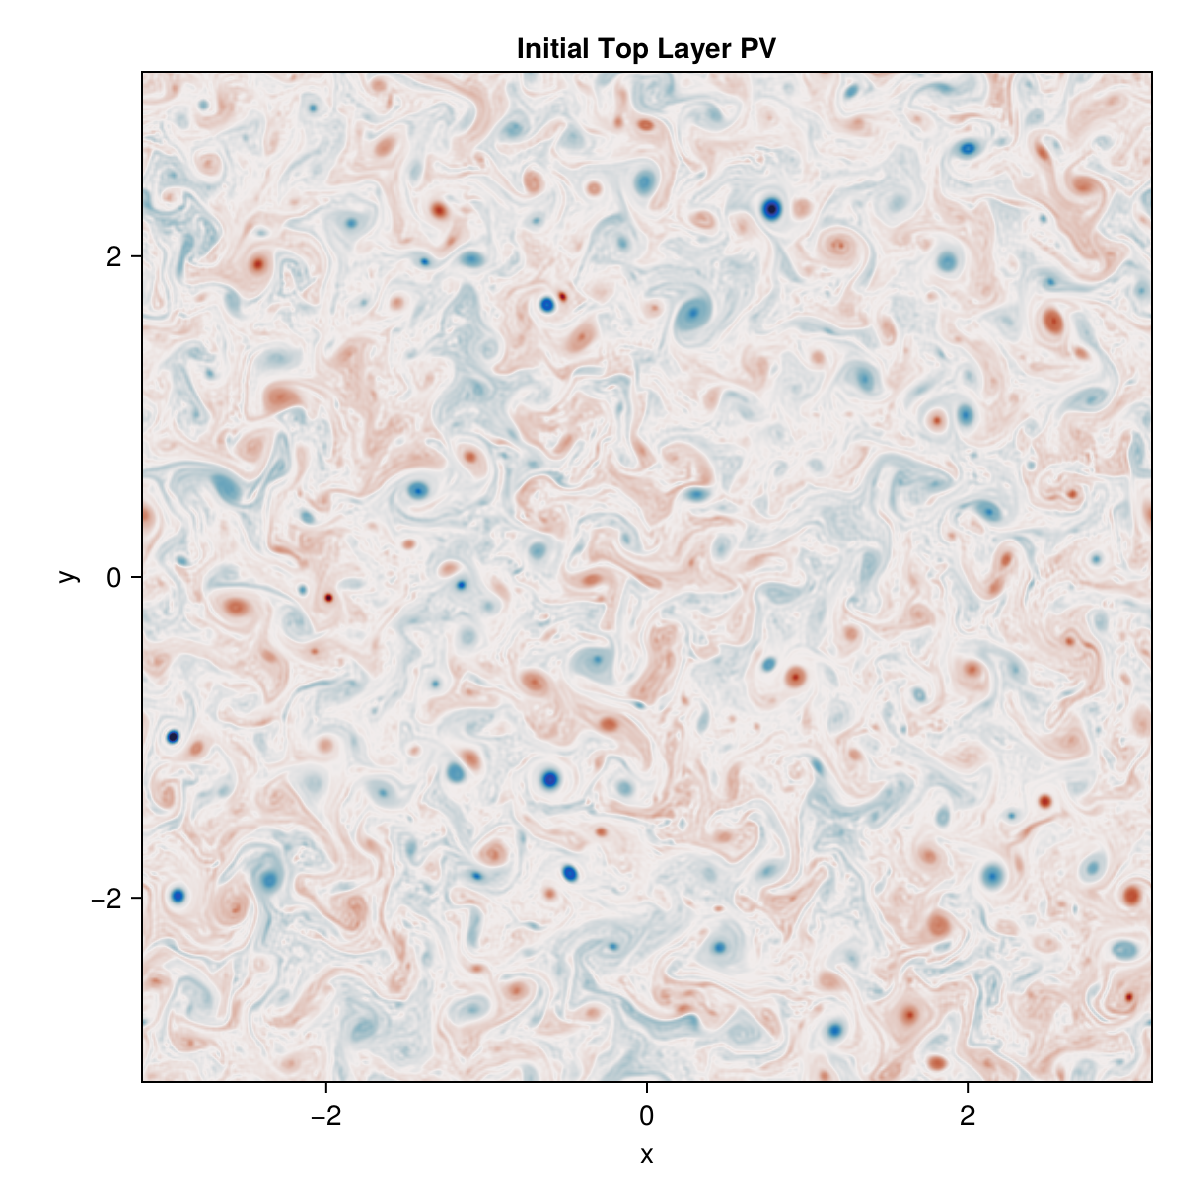

In [7]:
using Interpolations
field = prob.vars.q[:,:,1]
cmax = maximum(field)
q_field = linear_interpolation((grid.x, grid.y), field, extrapolation_bc = Periodic())
dims = 1024
plot_x = range(-grid.Lx/2, grid.Lx/2, dims)
plot_y = range(-grid.Lx/2, grid.Lx/2, dims)
plot_field = q_field(plot_x, plot_y)

fig = Figure(size=(600, 600))
ax = Axis(fig[1, 1]; title = "Initial Top Layer PV", xlabel="x", ylabel="y", aspect=1)
heatmap!(ax, plot_x, plot_y, plot_field, colormap=:balance, colorrange=(-cmax, cmax))

fig

In [17]:
u1_background  = Array{Float64}(undef, grid.nx, grid.ny)
v1_background  = Array{Float64}(undef, grid.nx, grid.ny)
ux1_background = Array{Float64}(undef, grid.nx, grid.ny)
uy1_background = Array{Float64}(undef, grid.nx, grid.ny)
vx1_background = Array{Float64}(undef, grid.nx, grid.ny)
vy1_background = Array{Float64}(undef, grid.nx, grid.ny)


velocity = Raytracing.Velocity(u1_background, v1_background)
grad_velocity = Raytracing.VelocityGradient(ux1_background, uy1_background, vx1_background, vy1_background)

temp_in_field = Array{Complex{Float64}}(undef, grid.nkr, grid.nl)
temp_out_field = Array{Float64}(undef, grid.nx, grid.ny)

avg_velocity = sum(sqrt.((prob.vars.u[:,:,1].^2 + prob.vars.v[:,:,1].^2)))/grid.nx/grid.ny
println(avg_velocity)
Fr = 0.2
scaled_field = Fr * prob.vars.ψh[:,:,1] / avg_velocity
scaled_field =prob.vars.ψh[:,:,1]
get_velocity_info(scaled_field, grid, (), velocity, grad_velocity, temp_in_field, temp_out_field);

sqrtNpackets = 6
Npackets = sqrtNpackets^2
packet_params = (f=1., Cg = 1., Npackets=Npackets)
initial_packets = generate_initial_wavepackets(grid.Lx, 2., Npackets, sqrtNpackets)

0.08408173486111212


36-element Vector{Main.Raytracing.Wavepacket}:
 Main.Raytracing.Wavepacket([-2.6179938779914944, -2.6179938779914944], [1.969615506024416, 0.34729635533386066], [0.0, 0.0])
 Main.Raytracing.Wavepacket([-2.6179938779914944, -1.5707963267948966], [1.8793852415718169, 0.6840402866513374], [0.0, 0.0])
 Main.Raytracing.Wavepacket([-2.6179938779914944, -0.5235987755982988], [1.7320508075688774, 0.9999999999999999], [0.0, 0.0])
 Main.Raytracing.Wavepacket([-2.6179938779914944, 0.5235987755982986], [1.532088886237956, 1.2855752193730785], [0.0, 0.0])
 Main.Raytracing.Wavepacket([-2.6179938779914944, 1.570796326794897], [1.2855752193730787, 1.532088886237956], [0.0, 0.0])
 Main.Raytracing.Wavepacket([-2.6179938779914944, 2.6179938779914944], [1.0000000000000002, 1.7320508075688772], [0.0, 0.0])
 Main.Raytracing.Wavepacket([-1.5707963267948966, -2.6179938779914944], [0.6840402866513376, 1.8793852415718166], [0.0, 0.0])
 Main.Raytracing.Wavepacket([-1.5707963267948966, -1.5707963267948966], [0.34

In [28]:
function trace_packets!(velocity, grad_velocity, packets, nsteps, nsubs, dt, packet_params)
    frames = 0:round(Int, nsteps / nsubs)
    clock = (t = t, step = 0)
    timestep = nsubs * dt
    
    t_hist = Array{Float64}(undef, 1+length(frames))
    x_hist = Array{Float64}(undef, 1+length(frames), Npackets, 2)
    k_hist = Array{Float64}(undef, 1+length(frames), Npackets, 2)
    # savepackets!(out, clock, packets)
    startwalltime = time()
    t_hist[1] = 0
    for i = 1:Npackets
        x_hist[1, i, 1] = packets[i].x[1]
        x_hist[1, i, 2] = packets[i].x[2]
        k_hist[1, i, 1] = packets[i].k[1]
        k_hist[1, i, 2] = packets[i].k[2]
    end
    for j=frames
        if (j % (1000 / nsubs) == 0)
            log = @sprintf("step: %04d, t: %.1f, walltime: %.2f min",
                           clock.step, clock.t, (time()-startwalltime)/60)
            println(log)
        end
        new_t = clock.t + timestep;
        Raytracing.solve!(velocity,  grad_velocity, 
            grid.x, grid.y, packet_params.Npackets, packets, dt, (clock.t, new_t), packet_params);
        t_hist[j+2] = new_t
        for i = 1:Npackets
            x_hist[j+2, i, 1] = packets[i].x[1]
            x_hist[j+2, i, 2] = packets[i].x[2]
            k_hist[j+2, i, 1] = packets[i].k[1]
            k_hist[j+2, i, 2] = packets[i].k[2]
        end
        # stepraysforward!(grid, packets, old_v, new_v, (old_t / packet_params.packetVelocityScale, new_t / packet_params.packetVelocityScale), packet_params);
        t = new_t;
        clock = (t = t, step = clock.step + nsubs)
        # savepackets!(out, clock, packets); # Save with latest velocity information
    end
    return t_hist, x_hist, k_hist
end

trace_packets! (generic function with 1 method)

In [29]:
nsteps = 50000
nsubs = 1

dt = 3e-3
t = 0.
packet_params = (f=1., Cg = 1., Npackets=Npackets)
packets = deepcopy(initial_packets)
t_hist, x_hist, k_hist = trace_packets!(velocity, grad_velocity, packets, nsteps, nsubs, dt, packet_params)

LoadError: InterruptException:

In [9]:
using JLD2
output_file = jldopen("change_this.jld2", "w")
output_file["x"] = x_hist
output_file["k"] = k_hist
output_file["t"] = t_hist
close(output_file)


In [13]:
using JLD2
input_file = jldopen("save_to_this_file.jld2", "r")
x_hist = input_file["x"]
k_hist = input_file["k"]
t_hist = input_file["t"]

50002-element Vector{Float64}:
   0.0
   0.003
   0.006
   0.009000000000000001
   0.012
   0.015
   0.018
   0.020999999999999998
   0.023999999999999997
   0.026999999999999996
   0.029999999999999995
   0.032999999999999995
   0.036
   ⋮
 149.9699999999015
 149.97299999990148
 149.97599999990146
 149.97899999990145
 149.98199999990143
 149.98499999990142
 149.9879999999014
 149.9909999999014
 149.99399999990138
 149.99699999990136
 149.99999999990135
 150.00299999990133

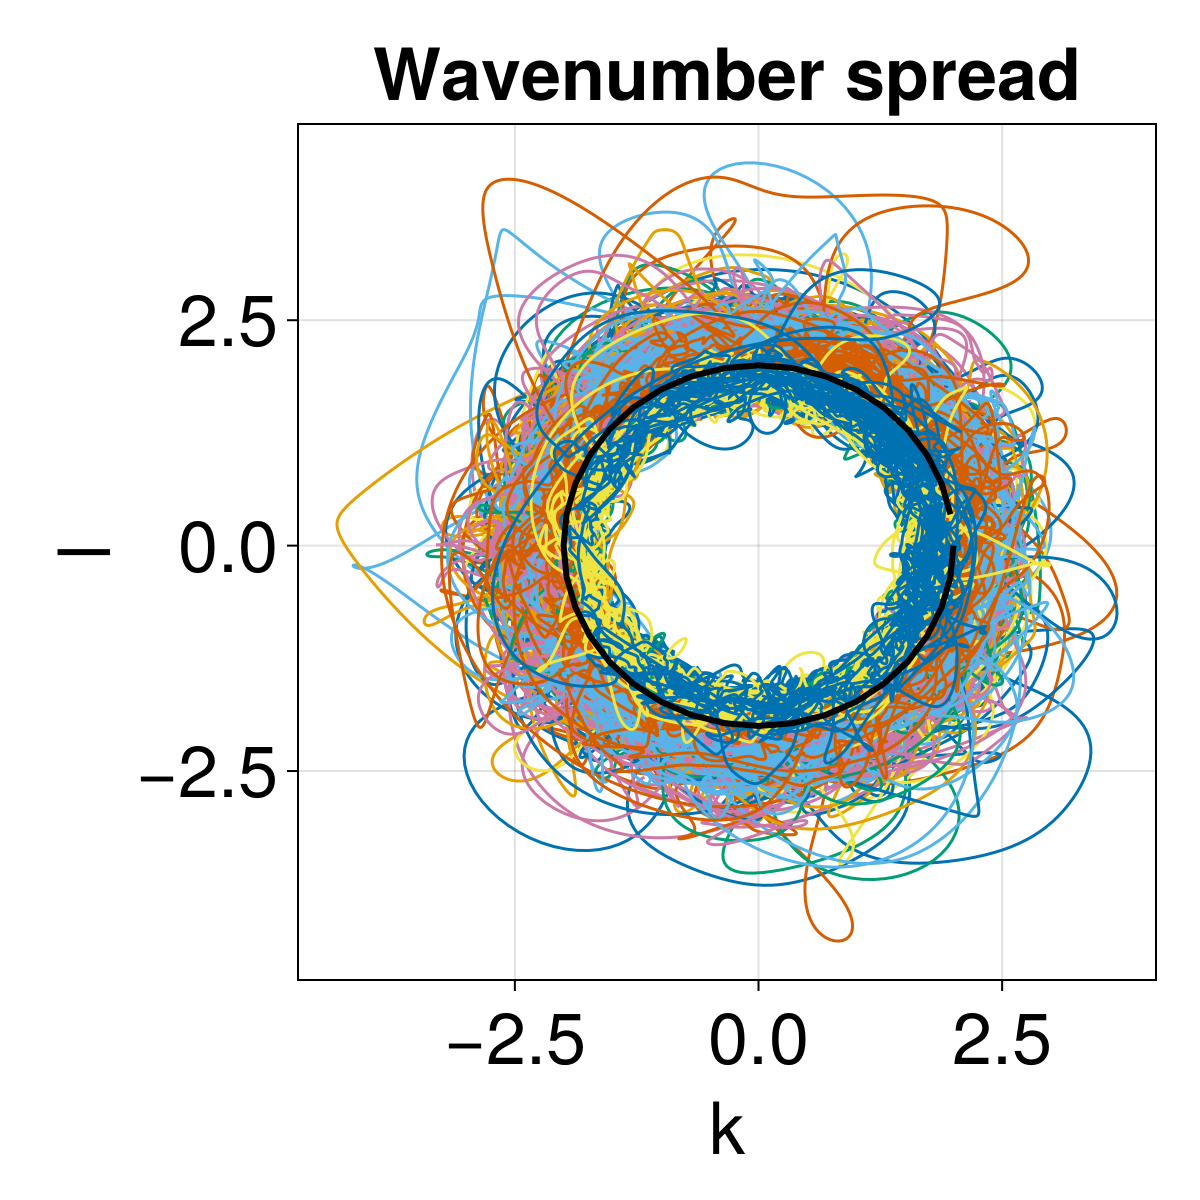

In [21]:
fig = Figure(size=(600, 600), fontsize=36)
ax = Axis(fig[1, 1]; title = "Wavenumber spread", xlabel="k", ylabel="l", aspect=1)
#title!(ax, "Wavenumber spread", fontsize=36)

for i=1:Npackets
    lines!(ax, k_hist[:,i,1], k_hist[:,i,2])
end
lines!(ax, k_hist[1,:,1], k_hist[1,:,2], color="black", linewidth=3)

save("wavenumber_spread.png", fig)
fig

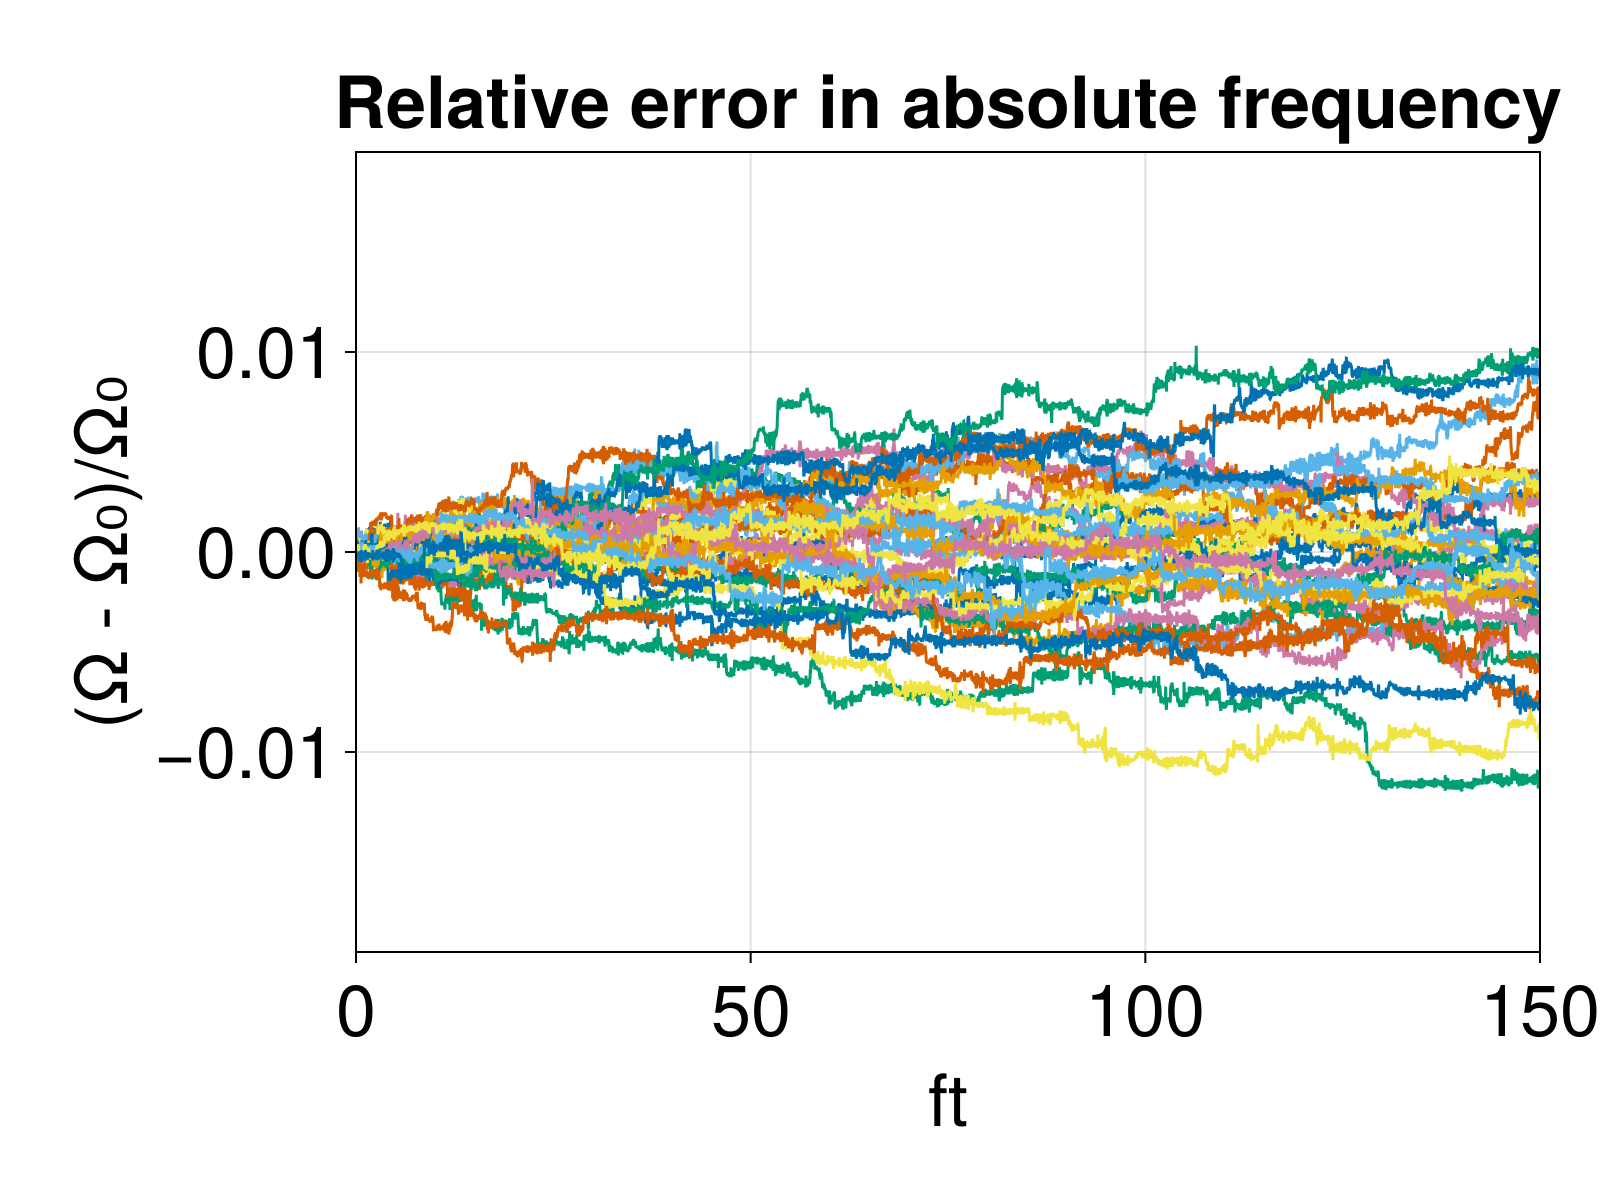

In [22]:
vel_itp = Raytracing.createVelocityInterpolator(velocity, grid.x, grid.y)
omega(k, l) = sqrt(packet_params.f^2 + packet_params.Cg^2*(k^2 + l^2))
Omega(x, y, k, l) = vel_itp.u(x, y) * k + vel_itp.v(x, y) * l + omega(k, l)

fig = Figure(size=(800, 600), fontsize = 36, figure_padding = 30)
ax = Axis(fig[1, 1]; 
        title = "Relative error in absolute frequency", xlabel="ft", ylabel="(Ω - Ω₀)/Ω₀",
        limits = ((0, maximum(t_hist)), (-0.02, 0.02))
)

for i=1:Npackets
    initial_omega = Omega(x_hist[1,i,1], x_hist[1,i,2], k_hist[1,i,1], k_hist[1,i,2])
    lines!(ax, t_hist, (Omega.(x_hist[:,i,1], x_hist[:,i,2], k_hist[:,i,1], k_hist[:,i,2]) .- initial_omega) / initial_omega)
end

save("relative_error.png", fig)
fig